In [1]:
import numpy as np
import centrex_TlF as centrex
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

C:\Users\ogras\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


FileNotFoundError: [WinError 2] The system cannot find the file specified

In [2]:
gnd_sel = centrex.states.QuantumSelector(J = [0,1,2,3,4,5,6], mF = 0)
exc_sel = centrex.states.QuantumSelector(J = [1,2,3,4,5], mF = 0, P = [-1,+1])

In [3]:
gnd = centrex.states.generate_coupled_states_ground_X(gnd_sel)
exc = centrex.states.generate_coupled_states_excited_B(exc_sel)

In [4]:
transitions = []
for idg, g in tqdm(enumerate(gnd), total = len(gnd)):
    for ide, e in enumerate(exc):
        ret = centrex.transitions.check_transition_coupled_allowed(g, e, 0)
        t = centrex.transitions.identify_transition(g,e)
        if t is not None:
            transitions.append([idg, ide, t])
transitions = np.array(transitions)

100%|██████████████████████████████████████████████████████████████████████| 26/26 [00:03<00:00,  6.84it/s]


In [5]:
%%time
# get frequencies in Hz
frequencies = centrex.transitions.generate_transition_frequencies(
    1.*gnd[transitions[:,0].astype(int)], 
    1.*exc[transitions[:,1].astype(int)]).real / (2*np.pi)

Wall time: 30.3 s


In [6]:
def unique(array):
    """Get unique values and indices of those values from an 
    arbitrary list/array/tuple.
    Numpy unique requires that the objects are sortable, this 
    doesn't.
    
    Args:
        array (np.ndarray, list): array/list to get unique items from
        
    Returns:
        (list, list): unique values and indices corresponding
                                    to those unique values
    """
    indices = []
    values = []
    for a in array:
        if a not in values:
            indices.append(np.where(array == a)[0])
            values.append(a)
    return values, indices

In [7]:
frequencies_unique = []
transitions_unique = []
for uni, indices in zip(*unique(transitions[:,2])):
    transitions_unique.append(transitions[:,2][indices[0]])
    frequencies_unique.append(frequencies[indices].mean())
frequencies_unique = np.array(frequencies_unique)
transitions_unique = np.array(transitions_unique)

In [8]:
indices = np.argsort(frequencies_unique)

df_unique = pd.DataFrame(
    {
        "frequency": frequencies_unique
    }
)
df_unique.index = transitions_unique
df_unique = df_unique.sort_values("frequency" )
df_unique

,frequency
Transition(O(6) F1'=9/2 F'=4),1.103248e+15
Transition(O(6) F1'=9/2 F'=5),1.103249e+15
Transition(O(6) F1'=7/2 F'=3),1.103249e+15
Transition(O(6) F1'=7/2 F'=4),1.103249e+15
Transition(O(5) F1'=7/2 F'=3),1.103275e+15
...,...
Transition(S(3) F1'=9/2 F'=5),1.103516e+15
Transition(T(2) F1'=11/2 F'=5),1.103555e+15
Transition(T(2) F1'=11/2 F'=6),1.103555e+15
Transition(T(2) F1'=9/2 F'=4),1.103556e+15


In [9]:
def find_nearby_transitions(transition, Δfrequency, transitions, frequencies):
    """Find transitions that are within Δfrequency of the specified transition
    
    Args:
        transition (LaserTransition): transition of interest
        Δfrequency (float): frequency range to within to search
        transitions (np.ndarray): LaserTransitions in a np.ndarray corresponding
                                    to the frequencies array
        frequencies (np.ndarray): frequencies corresponding to transitions
    
    Returns:
        (np.ndarray, np.ndarray): array of frequencies and array of transitions
                                    that are within Δfrequency of the transition
                                    of interest
    """
    # find index of transition of interest
    transition_idx = [idx for idx, t in enumerate(transitions) if t == transition]
    # frequency of transition of interest
    frequency_transition = frequencies[transition_idx]
    # find indices of transitions within Δfrequency of the transition of interest
    indices = np.where(np.abs(frequencies - frequency_transition) <= Δfrequency)[0]
    # filter transition of interest index
    indices = [idx for idx in indices if idx != transition_idx]
    return transitions[indices], frequencies[indices]

def find_nearby_transitions_df(transition, Δfrequency, transitions, frequencies):
    ts, fs = find_nearby_transitions(transition, Δfrequency, transitions, frequencies)
    df = pd.DataFrame(
        {"frequency": [transition.get_frequency()]}
    )
    df1 = pd.DataFrame(
        {"frequency": fs}
    )
    df = pd.concat([df, df1])
    df.index = [transition] + list(ts)
    df['Δfrequency [MHz]'] = (df.frequency - transition.get_frequency())/1e6
    return df

In [10]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def plot_nearby_transitions(transition, frequency, other_transitions, other_frequencies, Δfrequency = None):
    """Plot the transition of interest and nearby transitions
    
    Args:
        transition (LaserTransition): transition of interest
        frequency (float): frequency of transition of interest
        other_transitions (np.ndarray, list): array/list of nearby transitions
        other_frequencies (np.ndarray, list): array/list of frequencies of nearby transitions
        Δfrequency (float, optional): frequency range to within was searched
    """
    Δf = 25e6
    σg = 5e6
    frequency_offset = frequency
    
    freq_linspace = np.linspace(-Δf,Δf,201)
    g = gaussian(freq_linspace, 0, σg)
    
    fig, ax = plt.subplots(figsize = (8,5))
    
    # plot transition of interest
    ax.plot( (freq_linspace + frequency - frequency_offset ) / 1e6, g, '-',
            color = 'k', lw = 2, label = transition.get_string())
    
    # plot nearby transitions
    # find transitions that are too close to distinghuish in plot
    # current method is slightly overkill, now creates essentially a
    # directed graph in dictonary form, could be used for more intracte
    # plotting later
    indices_close = []
    for idx, f in enumerate(other_frequencies):
        idc = np.where(np.abs(other_frequencies - f) <= σg)[0]
        idc = [i for i in idc if i != idx]
        if len(idc) > 0:
            _  = [idx]
            _.extend(idc)
            indices_close.append(sorted(_))
    indices_close = np.unique(indices_close, axis = 0)
    indices_close = dict(indices_close)
    
    lines = []
    for idx, (freq, trans) in enumerate(zip(other_frequencies, other_transitions)):
        lines.append(
            ax.plot( (freq_linspace + freq - frequency_offset ) / 1e6, g, lw = 2, label = trans.get_string())[0]
        )
    for i,j in indices_close.items():
        lines[j].set_linestyle('--')
    
    
    ax.legend(fontsize = 13)
    ax.set_xlabel("[MHz]")
    ax.set_ylim(ymin = 0)
    ax.set_yticks([])
    if Δfrequency is not None:
        ax.set_xlim(
            (-Δfrequency -Δf + (frequency - frequency_offset) ) / 1e6, 
            (Δfrequency + Δf + (frequency - frequency_offset) ) / 1e6
        )
    ax.set_title(f"{transition.get_string()}", fontsize = 14)
    return fig, ax

In [11]:
amherst_transitions = [
    centrex.transitions.LaserTransition("R1", F1 = 3/2, F = 1),
    centrex.transitions.LaserTransition("R1", F1 = 3/2, F = 2),
    centrex.transitions.LaserTransition("R1", F1 = 5/2, F = 2),
    centrex.transitions.LaserTransition("R1", F1 = 5/2, F = 3),
    centrex.transitions.LaserTransition("Q1", F1 = 1/2, F = 0),
    centrex.transitions.LaserTransition("Q1", F1 = 1/2, F = 1),
    centrex.transitions.LaserTransition("Q1", F1 = 3/2, F = 1),
]

In [12]:
def style_row_transition_of_interest(v, props = "", **kwargs):
    transition = kwargs.get("transition", None)
    if v.name == transition:
        return [props] * len(v)
    else:
        return [None] * len(v)
        

In [13]:
Δfrequency = 500e6
for t in amherst_transitions:
    df_nearby = find_nearby_transitions_df(t, Δfrequency, df_unique.index.values, df_unique.frequency.values)
    df_nearby = df_nearby.sort_values(by = "frequency")
    df_nearby.index = [v.get_string() for v in df_nearby.index.values]
    styled = df_nearby.style.set_caption(f"Nearby transitions for {t.get_string()}").apply(
        style_row_transition_of_interest,
        props = 'color:white;background-color:blue;opacity: 50%;',
        transition = t.get_string(),
        axis = 1
    )
    display(styled)
    print("\n"*2)

,frequency,Δfrequency [MHz]
R(1) F1'=5/2 F'=3,1103421532520416.125000,-458.658993
R(1) F1'=3/2 F'=1,1103421991179409.000000,0.000000


,frequency,Δfrequency [MHz]
R(1) F1'=3/2 F'=2,1103422572788902.250000,0.000000


,frequency,Δfrequency [MHz]
R(1) F1'=5/2 F'=2,1103421296070618.500000,0.000000
R(1) F1'=5/2 F'=3,1103421532520416.125000,236.449798


,frequency,Δfrequency [MHz]
R(1) F1'=5/2 F'=2,1103421303113299.000000,-222.258022
R(1) F1'=5/2 F'=3,1103421525371320.875000,0.000000
R(1) F1'=3/2 F'=1,1103421984120009.500000,458.748689


,frequency,Δfrequency [MHz]
Q(1) F1'=1/2 F'=0,1103380227821895.250000,0.000000


,frequency,Δfrequency [MHz]
Q(1) F1'=1/2 F'=1,1103380791500099.500000,0.000000


,frequency,Δfrequency [MHz]
R(0) F1'=1/2 F'=1,1103394134206586.250000,-191.949765
Q(1) F1'=3/2 F'=1,1103394326156351.500000,0.000000
Q(2) F1'=5/2 F'=2,1103394633790299.000000,307.633947
Q(1) F1'=3/2 F'=2,1103394634357852.250000,308.201501


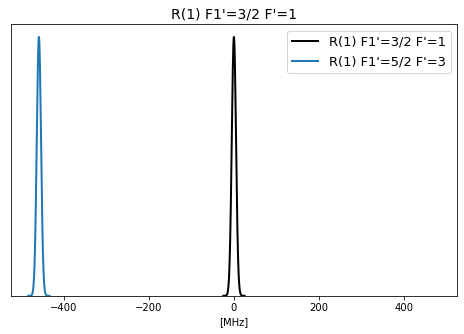

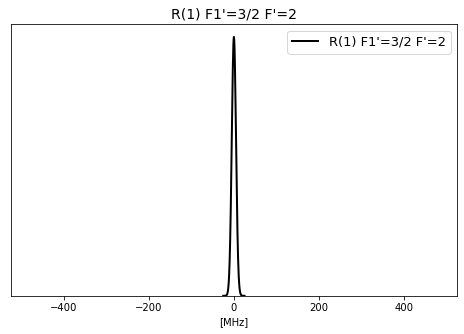

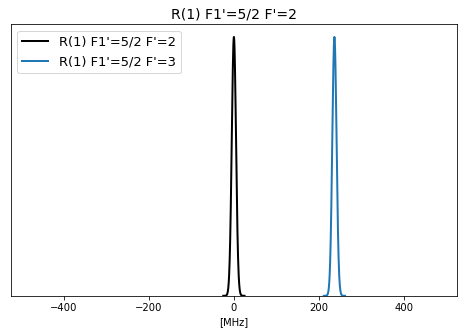

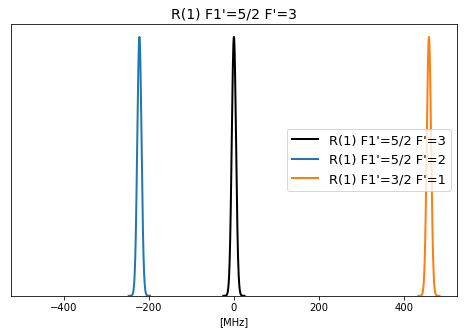

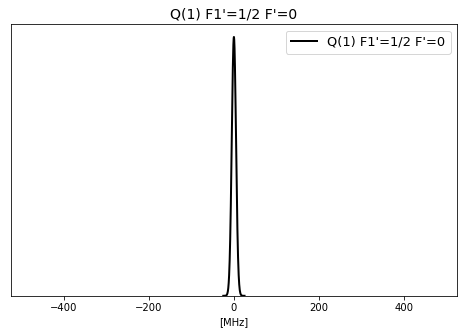

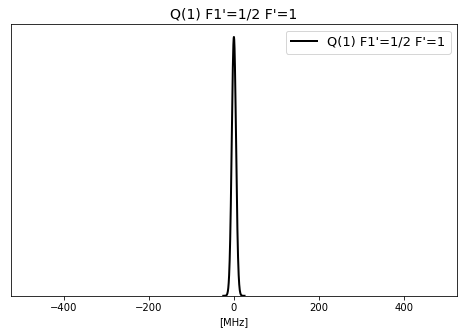

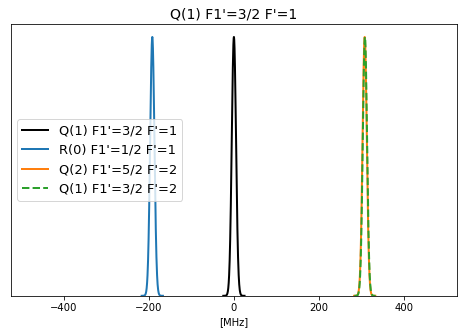

In [14]:
Δfrequency = 500e6
for t in amherst_transitions:
    plot_nearby_transitions(
        t, 
        t.get_frequency(), 
        *(find_nearby_transitions(
            t, Δfrequency, df_unique.index.values, df_unique.frequency.values
        )),
        Δfrequency = Δfrequency
    )

,frequency,Δfrequency [MHz]
R(0) F1'=3/2 F'=1,1103407652016809.000000,-307.969891
R(0) F1'=3/2 F'=2,1103407959986700.250000,0.000000


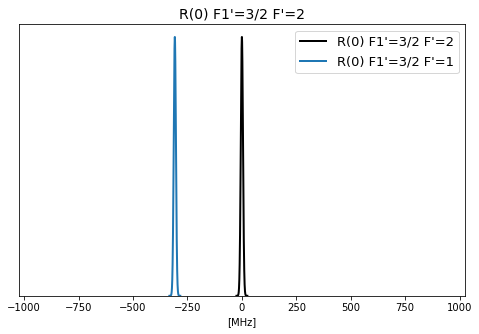

In [27]:
t = centrex.transitions.LaserTransition("R0", F1 = 3/2, F=2)
Δfrequency = 1e9

plot_nearby_transitions(
    t, 
    t.get_frequency(), 
    *(find_nearby_transitions(
        t, Δfrequency, df_unique.index.values, df_unique.frequency.values
    )),
    Δfrequency = Δfrequency
);
df_nearby = find_nearby_transitions_df(t, Δfrequency, df_unique.index.values, df_unique.frequency.values)
df_nearby = df_nearby.sort_values(by = "frequency")
df_nearby.index = [v.get_string() for v in df_nearby.index.values]
styled = df_nearby.style.set_caption(f"Nearby transitions for {t.get_string()}").apply(
    style_row_transition_of_interest,
    props = 'color:white;background-color:blue;opacity: 50%;',
    transition = t.get_string(),
    axis = 1
)
display(styled)